# Extracting historical climate (rainfall) data over selected basins

* **Products used:** 
ERA5

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.load_era5 import load_era5
from deafrica_tools.dask import create_local_dask_cluster

## Analysis Parameters

In [2]:
# Original shapefile from https://data.apps.fao.org/map/catalog/srv/api/records/57bb1c95-2f00-4def-886f
vector_file = 'data/OB_FWR_Hydrography_Okavango_Subasins_polygon.geojson'

# define time period of interest
time_range = '2013-12', '2021-05-31'

## Define areas of interest in the Okavango Basin

In [3]:
# load basin polygons
# Original shapefile from https://data.apps.fao.org/map/catalog/srv/api/records/57bb1c95-2f00-4def-886f-caee3d756da9
basin = gpd.read_file(vector_file)

# upstream include Cuito and Cubango subbasins
upstream = basin[basin.Subbasin.isin(['Cuito', 'Cubango'])]

# delta is part of the Okavango subbasin
delta = basin[basin.Subbasin.isin(['Okavango'])]

print(upstream)

   CLASS_ID  Longitude   Latitude Subbasin      Sph_Area      Sph_Len  Parts  \
0         0  19.003252 -15.179938    Cuito  5.902293e+10  2285720.103    1.0   
1         0  17.870032 -15.740153  Cubango  1.078813e+11  3071839.684    1.0   

   Vertices                                           geometry  
0    9326.0  POLYGON ((17.85205 -13.53846, 17.85205 -13.536...  
1   11314.0  POLYGON ((15.99370 -13.93323, 15.99370 -13.931...  


## Retrieve historical rainfall data over all areas of interest

In [4]:
# get historical rainfall for upstream and delta
bounds = pd.concat([upstream, delta]).total_bounds
lat = bounds[1], bounds[3]
lon = bounds[0], bounds[2]

In [5]:
# download ERA5 rainfall and aggregate to monthly
var = 'total_precipitation_24hr'
precip_1W = load_era5(var, lat, lon, time_range, reduce_func=np.sum, resample='1W').compute()

#resample to 3 month seasons
precip = precip_1W.resample(time='3M').sum()

# fix inconsistency in axis names
precip = precip.rename({'lat':'latitude', 'lon':'longitude'})
precip_1W = precip_1W.rename({'lat':'latitude', 'lon':'longitude'})

## Create area mask for upstream and okavango regions

In [6]:
upstream_raster = xr_rasterize(upstream, precip)
delta_raster = xr_rasterize(delta, precip)

## Calculate the total rainfall over each area

In [7]:
upstream_rainfall = precip[var].where(upstream_raster).sum(['latitude','longitude'])
okavango_rainfall = precip[var].where(delta_raster).sum(['latitude','longitude'])

upstream_rainfall_1W = precip_1W[var].where(upstream_raster).sum(['latitude','longitude'])

In [8]:
upstream_rainfall_1W = precip_1W[var].where(upstream_raster).sum(['latitude','longitude'])


## Export results as csv

In [9]:
upstream_rainfall.to_dataframe().drop('spatial_ref',axis=1).rename({'total_precipitation_24hr':'cumulative 3-month rainfall (mm)'},axis=1).to_csv(f'results/upstream_rainfall_{time_range[0]}_to_{time_range[1]}.csv')
okavango_rainfall.to_dataframe().drop('spatial_ref',axis=1).rename({'total_precipitation_24hr':'cumulative 3-month rainfall (mm)'},axis=1).to_csv(f'results/okavango_rainfall_{time_range[0]}_to_{time_range[1]}.csv')

upstream_rainfall_1W.to_dataframe().drop('spatial_ref',axis=1).rename({'total_precipitation_24hr':'cumulative 1-week rainfall (mm)'},axis=1).to_csv(f'results/upstream_rainfall_1W_{time_range[0]}_to_{time_range[1]}.csv')

## Visualize historical rainfall and compare to water extent changes

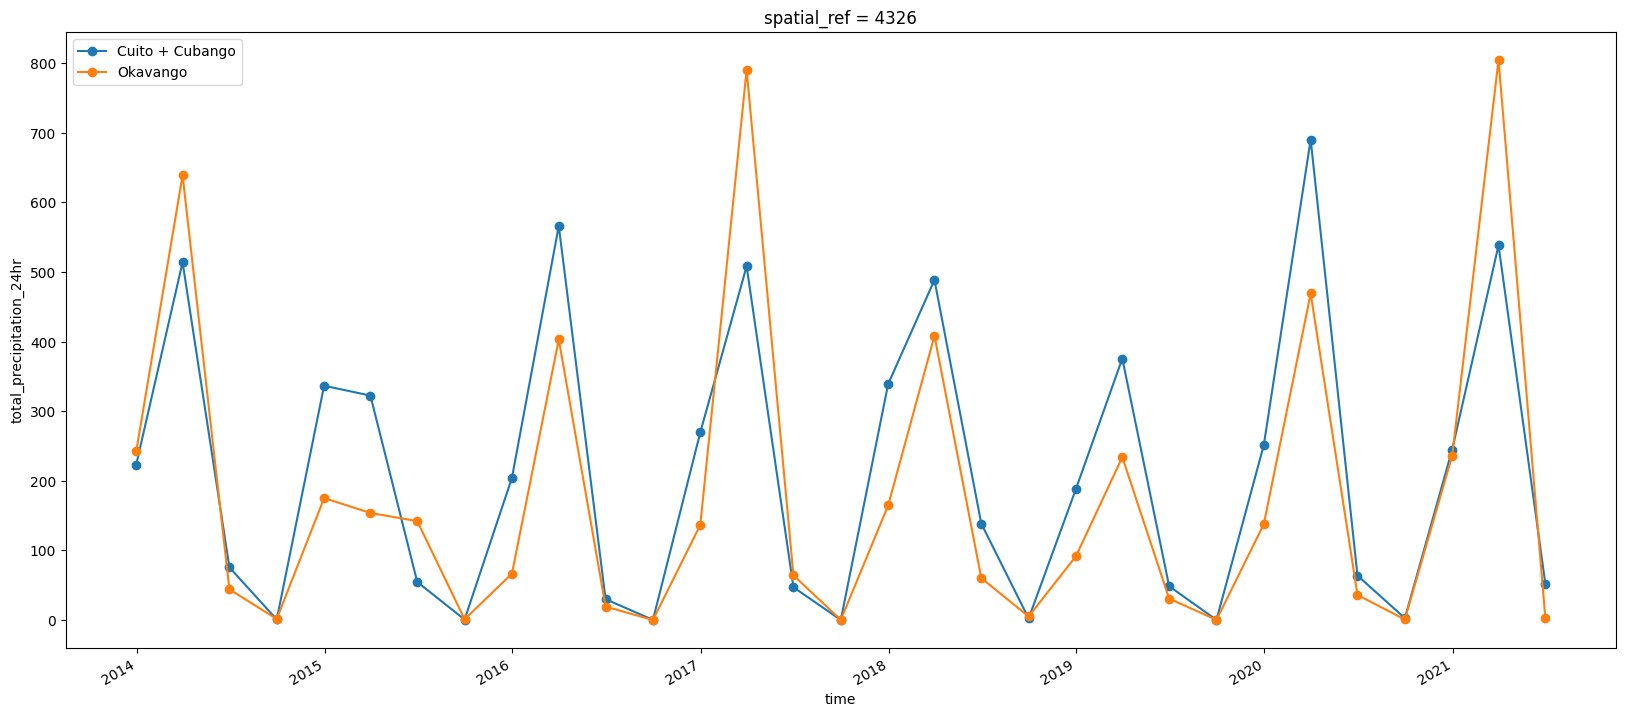

In [10]:
upstream_rainfall.plot(label='Cuito + Cubango', marker='o', figsize=(20,8));
okavango_rainfall.plot(label='Okavango', marker='o');
plt.legend();

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [11]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [12]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2024-02-01'